In [1]:
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pvtrace.scene.scene import Scene
from pvtrace.scene.renderer import MeshcatRenderer
from pvtrace.scene.node import Node
from pvtrace.trace.tracer import PhotonTracer
from pvtrace.geometry.sphere import Sphere
from pvtrace.material.material import Dielectric, LossyDielectric, Lumophore, Host
from pvtrace.light.ray import Ray
import logging

# Material types
In this notebook we will continue with the same example in quick start 1 but investigate different material types.

Let's define the original scene.

In [2]:
world = Node(
    name="world (air)",
    geometry=Sphere(
        radius=10.0,
        material=Dielectric.air()
    )
)
sphere = Node(
    name="sphere (glass)",
    geometry=Sphere(
        radius=1.0,
        material=Dielectric.glass()
    ),
    parent=world
)
ray = Ray(
    position=(-1.0, 0.0, 0.9),
    direction=(1.0, 0.0, 0.0),
    wavelength=600.0
)
scene = Scene(world)
tracer = PhotonTracer(scene)

## Dielectric material

In pvtrace a dielectric material is a material types that only has a refractive index attribute; it only interacts with rays by reflection and refraction, calculated by the Fresnel equations. This is useful but slightly limited compared to the other material types available.

Let's trace 100 rays into the scene with the sphere of the dielectric material.

In [3]:
vis = MeshcatRenderer()
vis.render(scene)
for _ in range(100):
    path = tracer.follow(ray)
    vis.add_ray_path(path)
    time.sleep(0.001)  # allow the renderer a chance to redraw
vis.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


## Lossy dielectric material

A lossy dielectric has a refractive index attribute and an absorption coefficient; it refracts, reflects and absorbs rays. When rays are absorbed they are killed and no longer traced.

Let's change the material attached to the sphere. Here we make a lossy dielectric with an absorption coefficient and refractive index defined between 300nm to 4000nm. The refractive index is 1.5 and the absorption coefficient is 5cm$^{-1}.$

In [4]:
world = Node(
    name="world (air)",
    geometry=Sphere(
        radius=10.0,
        material=Dielectric.air()
    )
)
sphere = Node(
    name="sphere (glass)",
    geometry=Sphere(
        radius=1.0,
        material=LossyDielectric.make_constant((300, 4000), 1.5, 5.0)
    ),
    parent=world
)
ray = Ray(
    position=(-1.0, 0.0, 0.9),
    direction=(1.0, 0.0, 0.0),
    wavelength=600.0
)
scene = Scene(world)
tracer = PhotonTracer(scene)

In [5]:
vis = MeshcatRenderer()
vis.render(scene)
for _ in range(10):
    path = tracer.follow(ray)
    vis.add_ray_path(path)
    time.sleep(0.001)  # allow the renderer a chance to redraw
vis.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


To see that the ray path length inside the sphere is attenuated, click Open Controls in the meshcat viewer, open the meshcat node, and uncheck "world (air)". Now it is highly unlikely that the ray will travel more than a few millimeters.

## Lumophore material

The lumophore material has absorption coefficient, emission spectrum and quantum yield attributes, but does not have a refractive index attribute. Let's make a very simple absorption coefficient and emission spectrum for this material. The quantum yield is the probability that re-emission occurs after a ray has been absorbed.

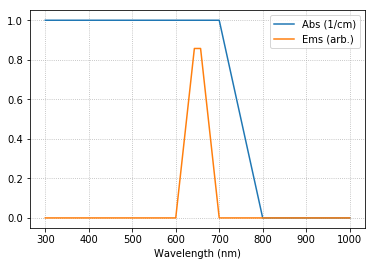

In [6]:
def make_absorprtion_coefficient(x_range, wavelengths, absorption_coefficient, cutoff_range, min_alpha=0):
    wavelength1, wavelength2 = cutoff_range
    alpha = absorption_coefficient
    halfway = wavelength1 + 0.5 * (wavelength2 - wavelength1)
    x = [x_range[0], wavelength1, halfway, wavelength2, x_range[1]]
    y = [alpha, alpha, 0.5 * alpha, min_alpha, min_alpha]
    abs_coeff = np.interp(wavelengths, x, y)
    return abs_coeff

def make_emission_spectrum(x_range, wavelengths, cutoff_range, min_ems=0):
    wavelength1, wavelength2 = cutoff_range
    halfway = wavelength1 + 0.5 * (wavelength2 - wavelength1)
    x = [x_range[0], wavelength1, halfway, wavelength2, x_range[1]]
    y = [min_ems, min_ems, 1.0, min_ems, min_ems]
    abs_coeff = np.interp(wavelengths, x, y)
    return abs_coeff


x_range = (300, 1000)
wavelength = np.linspace(*x_range)
abs_coef = make_absorprtion_coefficient(x_range, wavelength, 1.0, (700, 800))
ems_spec = make_emission_spectrum(x_range, wavelength, (600, 700))
plt.plot(wavelength, abs_coef, label="Abs (1/cm)")
plt.plot(wavelength, ems_spec, label="Ems (arb.)")
plt.xlabel("Wavelength (nm)")
plt.legend()
plt.grid(linestyle="dotted")

In [7]:
world = Node(
    name="world (air)",
    geometry=Sphere(
        radius=10.0,
        material=Dielectric.air()
    )
)

# Make the Lumophore material here
lumophore = Lumophore(
    np.column_stack((wavelength, abs_coef)),  # abs. coef. spectrum
    np.column_stack((wavelength, ems_spec)),  # emission spectrum
    1.0  # quantum yield
)  

sphere = Node(
    name="sphere (glass)",
    geometry=Sphere(
        radius=1.0,
        material=lumophore  # assign it here
    ),
    parent=world
)
ray = Ray(
    position=(-1.0, 0.0, 0.9),
    direction=(1.0, 0.0, 0.0),
    wavelength=600.0
)
scene = Scene(world)
tracer = PhotonTracer(scene)

In [8]:
vis = MeshcatRenderer()
vis.render(scene)
for _ in range(10):
    path = tracer.follow(ray)
    vis.add_ray_path(path)
    time.sleep(0.001)  # allow the renderer a chance to redraw
vis.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7007/static/


The orange ray enters the lumophore sphere, some rays can pass directly through, unabsorbed, because the absorption coefficient is faily low compared to the thickness of the sphere. Others are absorbed and re-emitted and longer (reshifted) wavelengths. These are the red rays, which branch from the orange ray path. They are locations where an orange ray has been absorbed and a re-emission event occurs.

Note that the there is no refraction at the interfaces of a lumophore material. As mentioned before, this is because it does not have an refractive index attribute and therefore pvtrace does not apply any refraction at the interfaces.

## Host material

A host material brings all of the above building blocks together and is probably the most interesting material type for uses for the software. It has a refractive index, absorption coefficient, emission spectrum and a quantum yield.

Luminescent solar concentrators, and related devices, are comprised of a lumophores which are typically blended with a polymer host matrix. The host provides the dominant contribution to bulk refractive index. This is reason why lumophore materials in pvtrace do not have a refractive index attribute. Moreover, the refractive index of the host is used and multiple lumophores can be added to a single host material.

In [9]:
world = Node(
    name="world (air)",
    geometry=Sphere(
        radius=10.0,
        material=Dielectric.air()
    )
)

sphere = Node(
    name="sphere (glass)",
    geometry=Sphere(
        radius=1.0,
        material=Host(
            np.column_stack( # refractive index spectrum
                (wavelength,
                 np.ones(wavelength.size) * 1.5)
            ), 
            [lumophore],  # list of lumophores, reuse the one we already have.
        )
    ),
    parent=world
)
ray = Ray(
    position=(-1.0, 0.0, 0.9),
    direction=(1.0, 0.0, 0.0),
    wavelength=600.0
)
scene = Scene(world)
tracer = PhotonTracer(scene)

In [10]:
vis = MeshcatRenderer()
vis.render(scene)
for _ in range(10):
    path = tracer.follow(ray)
    vis.add_ray_path(path)
    time.sleep(0.001)  # allow the renderer a chance to redraw
vis.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7008/static/


The visualisation shows refraction upon enter or exiting the sphere. Also, the paths now taken are now much more complex because of internal reflection which increases the path length through the lumophore material resulting in more absorption and reemission events.

In the next tutorial we will introduce light sources which makes generating rays that sample a realistic spectrum trivial.